# Implementing the Perceptron Algorithm
Mihir Singh

## Abstract
This blog posts first implements a perceptron algorithm and a minibatch perceptron algorithm. For the perceptron algorithm, experiments were run to check how it performed on linearly separable data, non-linearly separable data, and data with more than 2 dimensions. Experiments with the minibatch perceptron algorithm first focused on its performance compared to the regular perceptron algorithm, its performance on data with multiple dimensions, and its ability to converge when looking at all the data in a single iteration. Through this process, I developed an understanding of the perceptron algorithm and how it can be improved upon with a minibatch algorithm. 

### Metadata block

In [259]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer
from perceptronMB import PerceptronMB, PerceptronOptimizerMB

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Implementation
The code for the perceptron is [here](https://github.com/mihirBSingh/mihirBSingh.github.io/blob/main/posts/implementing-perceptron/perceptron.py).

For our experiments we will use data from the in-class perceptron warmup which we know is linearly separable.

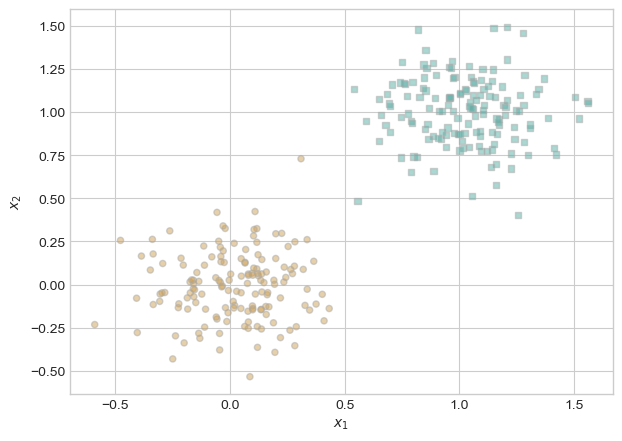

In [260]:
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
torch.manual_seed(1234)

def perceptron_data(n_points = 300, noise = 0.2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,2))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y

X, y = perceptron_data(n_points = 300, noise = 0.2)

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = perceptron_data()
plot_perceptron_data(X, y, ax)

From this we get a visual confirmation that our data is linearly separable. We should first check if our perceptron probably works by running it on our minimal training loop. We know it works if our perceptron converges and we achieve a loss of 0. 

In [261]:
from perceptron import Perceptron, PerceptronOptimizer

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # dangerous -- only terminates if data is linearly separable
    # not part of the update: just for tracking our progress  
    loss = p.loss(X, y) 
    loss_vec.append(loss)  
    
    # look at a single data point - consulted with Sophie Seiple to get single point  
    i = torch.randint(n, size = (1,))
    xi = X[[i],:]
    yi = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(xi, yi)
    
    if(loss == 0):
        print(loss)
    

tensor(0.)


We see that our tensor eventually becomes 0, so we are indeed converging on 0 and our perceptron is probably correct.

## Part B: Experiments
Now we can experiment with our perceptron and look at when the data is linearly separable, not linearly separable, and look at how the perceptron works in 2 dimensions.

### Experiment 1
We can use the same data from the example above (since we know that the data is linearly separable) and visualize the process of a perceptron finding a line the separates the data.

In [262]:
# Code below provided by Professor Phil Chodrow

from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

# functions for plotting perceptron data
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")


Just to be sure, let's look at the data first to confirm it looks linearly separable visually.

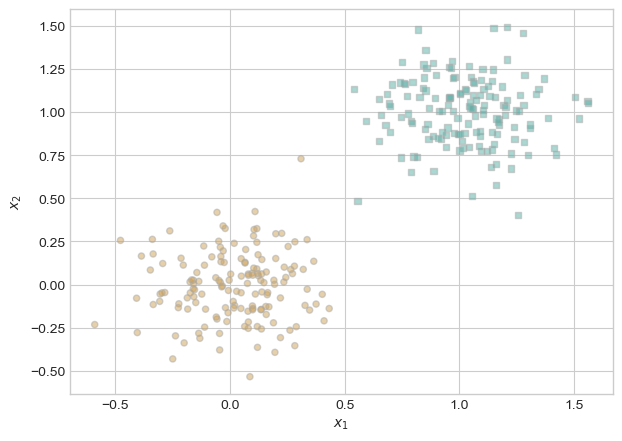

In [263]:
fig, ax = plt.subplots(1, 1)
plot_perceptron_data(X,y, ax)

Indeed, our data looks linearly separable. Now let's run our perceptron.

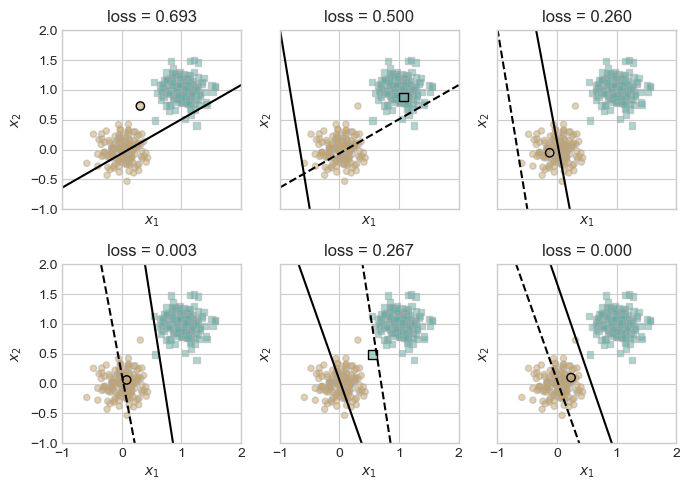

In [264]:
# Parts of code for visualization provided by Professor Phil Chodrow
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}


while loss > 0:
    # we are always still look at a single data point
    i = torch.randint(n, size = (1,))
    xi = X[[i],:]
    yi = y[i]
    
    ax = axarr.ravel()[current_ax]
    
    # save the old value of w for plotting later
    old_w = torch.clone(p.w)
    
    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value     
    local_loss = opt.step(xi, yi)
    loss = p.loss(X, y).item()
    loss_vec.append(loss)
    
    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if local_loss > 0:
        plot_perceptron_data(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[y[i].item()]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1
        
plt.tight_layout()


We can see that our perceptron becomes more accurate, converging on the correct answer. Another way to visualize our perceptron's accuracy is through a loss graph. 

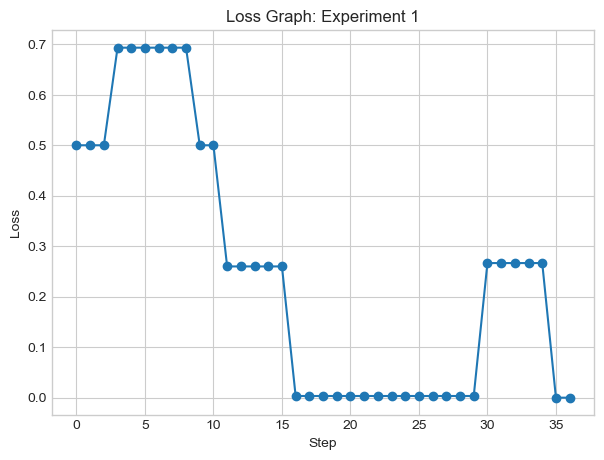

final loss:  0.0


In [265]:
# Loss graph
def loss_graph(loss_vec):
    plt.plot(loss_vec, marker='o', linestyle='-')
    plt.title('Loss Graph: Experiment 1')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.show()
    print("final loss: ", loss_vec[len(loss_vec)-1])
    
loss_graph(loss_vec=loss_vec)

We see that eventually (after may steps) we eventually do reach a loss of 0., but our loss graph shows the accuracy of the perceptron for every step over time.

Let's see what the decision boundary looks like on the final iteration.

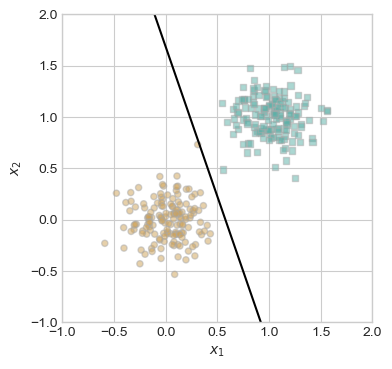

In [266]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)
draw_line(p.w, -1, 2, ax, color = "black")

We see that on the final step, the perceptron settles on a line that accurately separated all the data.

### Experiment 2
We've looked at the perceptron's accuracy when we know that the data is linearly separable. Now we can look at how a perceptron will perform when we know that the data is not linearly separable.

To do this, we first need to create data that we know is not linearly separable. We can use the same perceptron_data function from before, but we can instead set it so that the noise is higher. This has the effect of points from the different classes crossing each other's boundaries and thus making the data not linearly separable.

In [267]:
X, y = perceptron_data(noise=0.5)
y_ = (y+1)/2


Let's also plot the training and testing data for a visual inspection.

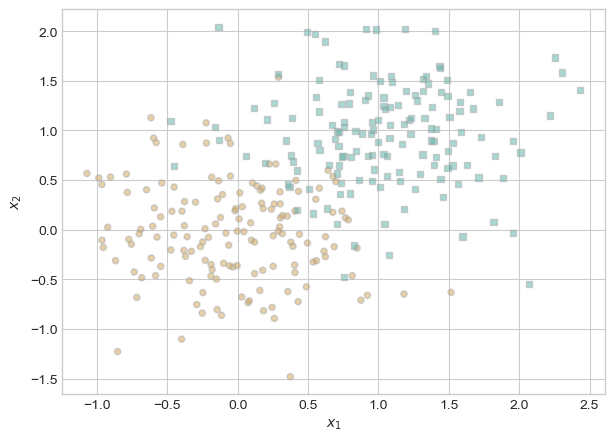

In [268]:
fig, ax = plt.subplots(1, 1)
plot_perceptron_data(X,y, ax)

Now we can visually see that out data is not perfectly linearly separable.

Let's begin training our perceptron. We will loop through for 1000 iterations. Let's see what we come up with after 500 and then finally when we finish at 1000 iterations

0.1666666716337204


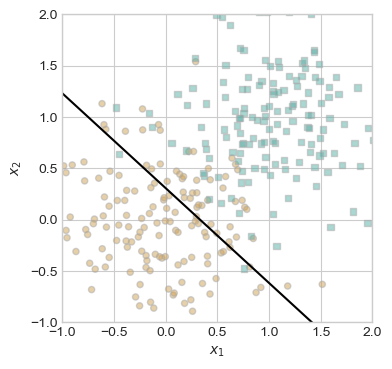

In [269]:
# Initialize perceptron
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

loss_vec = []

# Training loop to 500
iterations = 0
while iterations < 500:
    i = torch.randint(n, size = (1,))
    xi = X[[i],:]
    yi = y[i]
    local_loss = opt.step(xi, yi)
    loss = p.loss(X, y).item()
    iterations += 1
    loss_vec.append(loss)
    
# Plot perceptron after 500 iterations
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)
draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
print(loss)

It is somewhat accurate, but it's a stretch to say perfect like in experiment 1. Let's go to 1000  iterations. For the final iteration, we will also plot the decision boundary of the perceptron before we stopped iterating.

loss: 0.1066666692495346


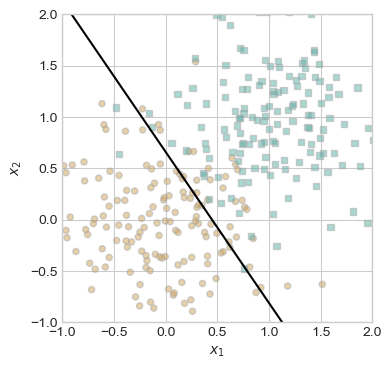

In [270]:
# Training loop to 1000
iterations = 0
loss_vec = []

while iterations < 1000:
    i = torch.randint(n, size = (1,))
    xi = X[[i],:]
    yi = y[i]
    local_loss = opt.step(xi, yi)
    loss = p.loss(X, y).item()
    iterations += 1
    loss_vec.append(loss)
    
# Plot perceptron after 500 iterations (with decision boundaries)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)
draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
print("loss:", loss)

We see here that our loss decreases slightly. Let's take a look at the loss over time.

1000


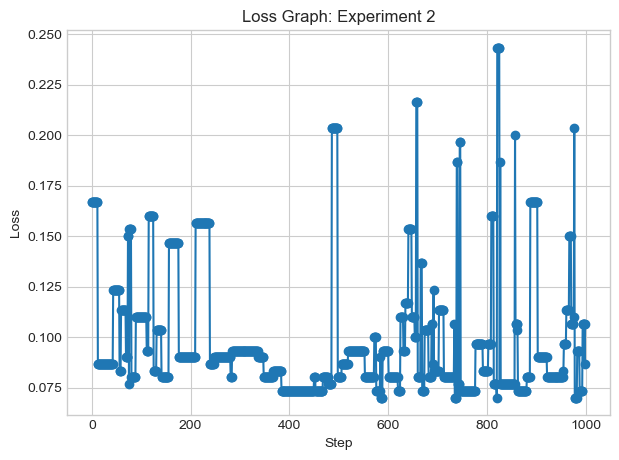

final loss:  0.1066666692495346


In [271]:
print(len(loss_vec))
plt.plot(loss_vec, marker='o', linestyle='-')
plt.title('Loss Graph: Experiment 2')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()
print("final loss: ", loss_vec[len(loss_vec)-1])

We can see that we can't say the loss generally decreases and converges on an answer - like we could generalize in part 1.

### Experiment 3
Now we will look at the perceptron algorithm working in more than two dimensions. To do this, we can run our perceptron algorithm on data with 5 features. 

First we need to generate perceptron data with 5 features. To do this we need to modify the perceptron_data function that we have been using. We'll also make the noise 0.35 (which is just the average of the noises from the pervious experiments)

In [272]:
def multi_dim_perceptron_data(n_points = 300, noise = 0.35, dim=5):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points, dim))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y

X, y = multi_dim_perceptron_data(dim=5)

We can look at the score of our perceptron over the training period to help us answer if the data is linearly separable. First we need to run our algorithm.

In [273]:
# rerun perceptron for experiment 3
# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)
loss = 1
loss_vec = []
scores = []
while loss > 0:
    i = torch.randint(n, size = (1,))
    xi = X[[i],:]
    yi = y[i]
    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 
    local_loss = opt.step(xi, yi)
    scores.append( p.score(X))
    loss = p.loss(X, y).item()
    loss_vec.append(loss)

Now to check if the data is linearly separable, we need to check if all the dot products between the weight vector w and feature vector xi are the same signs. This is because if the score and the target vector have opposite signs then the perceptron needs to update and we have not found a perfectly correct answer.

In [274]:
classification = p.score(X)*y
classification.min()

tensor(0.3203)

Since our minimum value in  classification is 0.0`68 we know that for any value of i, <w,xi> > 0  if y = 1, and thus we have a linearly separable dataset. 

To be extra sure we can also look at the loss and see if the perceptron converges such that it comes to the right answer and has a loss of 0.

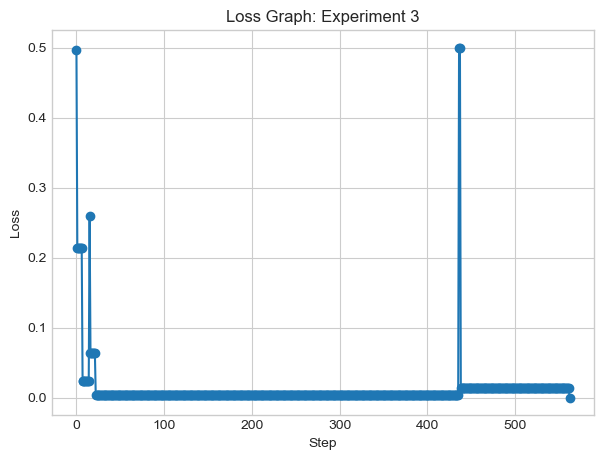

final loss:  0.0


In [275]:
plt.plot(loss_vec, marker='o', linestyle='-')
plt.title('Loss Graph: Experiment 3')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()
print("final loss: ", loss_vec[len(loss_vec)-1])

We see that our loss does indeed eventually go to 0 further indicating our perceptron settled on a hyperplane that perfectly separates the data. 

Therefore, the dataset in this experiment is linearly separable

## Part C: Minibatch Perceptron


Now we can look at how a minibatch perceptron performs. Instead of looking at a single point during each iteration, we will look at k randomly selected points. In addition to this change we add a learning rate alpha that changes how much the weights change with each iteration.

To do this we should update our grad function.
The code for the grad function and the whole minibatch perceptron function is [here](https://github.com/mihirBSingh/mihirBSingh.github.io/blob/main/posts/implementing-perceptron/perceptronMB.py).

With our implmentation of the minibatch perceptron we can canduct a few experiments.

### Experiment 1
We should first check to see that our minibatch perceptron performs similarly to a regular perceptron when it is only looking at one point (just like a regular perceptron). In this case, k = 1.

We will first look at how a minibatch perceptron performs compared to a regular perceptron when the data is linearly separable. To do this we will see if the minibatch perceptron converges to a loss of 0 and look at its loss graph.

tensor(0.)


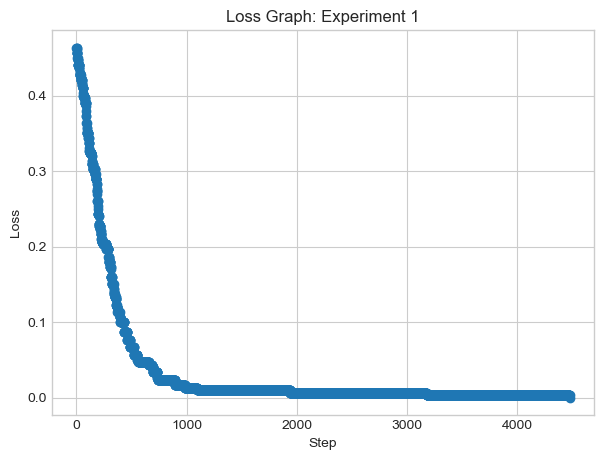

final loss:  tensor(0.)


In [276]:
from perceptronMB import PerceptronMB, PerceptronOptimizerMB
perceptron_data(n_points = 300, noise = 0.2)

# instantiate a model and an optimizer
p = PerceptronMB() 
opt = PerceptronOptimizerMB(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # dangerous -- only terminates if data is linearly separable
    # not part of the update: just for tracking our progress  
    loss = p.loss(X, y) 
    loss_vec.append(loss)  
    
    # get k points - code provided by Professor Phil Chodrow
    k = 1
    ix = torch.randperm(X.size(0))[:k]
    xi = X[ix,:]
    yi = y[ix]
    
    # perform a perceptron update using the random data point
    opt.step(xi, yi)
    
    if(loss == 0):
        print(loss)

loss_graph(loss_vec=loss_vec)

It takes more steps, but we do find that the perceptron converges to a loss of 0.

Now let's look at how the minibatch perceptron performs with overlapping data.

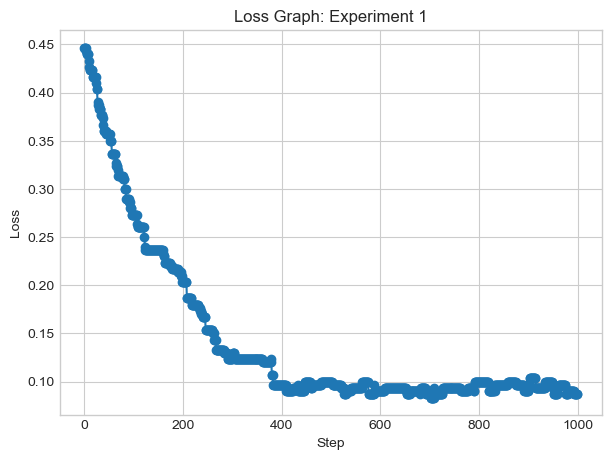

final loss:  0.08666666597127914


In [277]:
X, y = perceptron_data(noise=0.5)

# instantiate a model and an optimizer
p = PerceptronMB() 
opt = PerceptronOptimizerMB(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

iterations = 0
while iterations < 1000: 
    # not part of the update: just for tracking our progress  
    loss = p.loss(X, y).item()
    loss_vec.append(loss)
    
    # get k points - code provided by Professor Phil Chodrow
    k = 1
    ix = torch.randperm(X.size(0))[:k]
    xi = X[ix,:]
    yi = y[ix]
    
    # perform a perceptron update using the random data point
    opt.step(xi, yi)
    
    if(loss == 0):
        print(loss)
        
    iterations += 1

loss_graph(loss_vec=loss_vec)


After 1000 iterations we see that just like the regular perceptron, the minibatch perceptron struggles a little bit but still finds a hyperplane with a low loss.

## Experiment 2
Now looking at 5 dimensional data where k=10, we should also find that the minibatch perceptron finds a separating line.

tensor(0.)


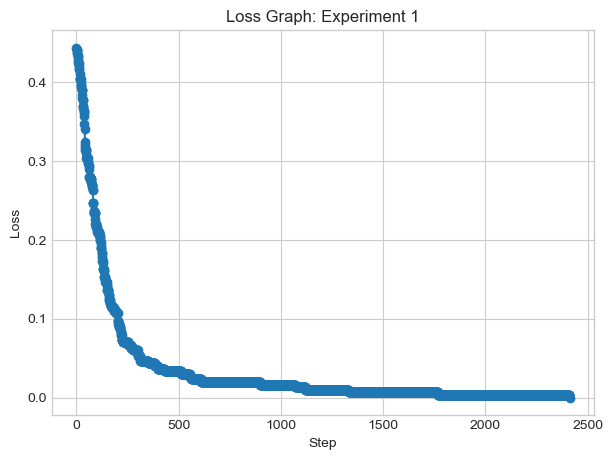

final loss:  tensor(0.)


In [278]:
from perceptronMB import PerceptronMB, PerceptronOptimizerMB
X, y = multi_dim_perceptron_data(n_points = 300, noise = 0.2, dim=5)

# instantiate a model and an optimizer
p = PerceptronMB() 
opt = PerceptronOptimizerMB(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # dangerous -- only terminates if data is linearly separable
    # not part of the update: just for tracking our progress  
    loss = p.loss(X, y) 
    loss_vec.append(loss)  
    
    # get k points - code provided by Professor Phil Chodrow
    k = 10
    ix = torch.randperm(X.size(0))[:k]
    xi = X[ix,:]
    yi = y[ix]
    
    # perform a perceptron update using the random data point
    opt.step(xi, yi)
    
    if(loss == 0):
        print(loss)

loss_graph(loss_vec=loss_vec)

As expected, the minibatch perceptron does indeed find a separating line.

### Experiment 3
Now what happens if k = n, that is we check the entire data set at once. Even if the data is not linearly separable, our minibatch perceptron should be able to converge.

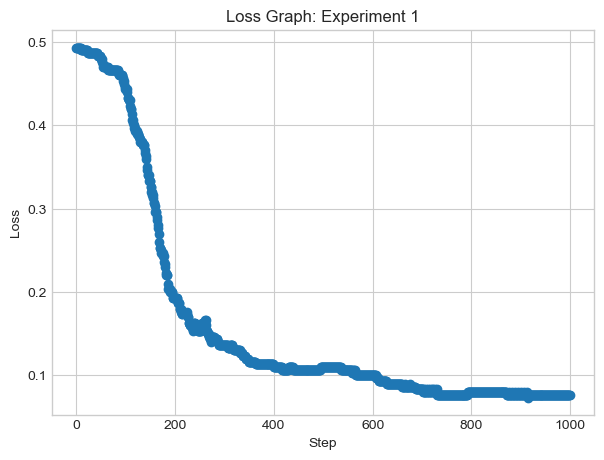

final loss:  0.07666666805744171


In [279]:
from perceptronMB import PerceptronMB, PerceptronOptimizerMB
X, y = perceptron_data(n_points = 300, noise = 0.5)
# instantiate a model and an optimizer
p = PerceptronMB() 
opt = PerceptronOptimizerMB(p)

# for keeping track of loss values
loss_vec = []

n = X.size()[0]
iterations = 0
while iterations < 1000: # dangerous -- only terminates if data is linearly separable
    # not part of the update: just for tracking our progress  
    loss = p.loss(X, y).item()
    loss_vec.append(loss)  
    
    # get k points - code provided by Professor Phil Chodrow
    k = n
    ix = torch.randperm(X.size(0))[:k]
    xi = X[ix,:]
    yi = y[ix]
    
    # perform a perceptron update using the random data point
    opt.step(xi, yi)
        
    iterations += 1

loss_graph(loss_vec=loss_vec)

We see that our loss converges to around 0.07, which is pretty small, even though the data is not linearly separable.

## Part D
The runtime complexity of a single iteration is O(N) where N is the number of features (the size of a single row in the feature matrix) This is because the number of computations that occur in a single iteration depends on the dot product between w and Xi where X is the feature matrix and i is a single row in the matrix.

The minibatch is essentially the same but instead of looking at just one row of the feature matrix, you are looking at k rows in a single iteration. So the runtime becomes O(KN) where K is the number of rows you are looking at in a single iteration.

Perceptron grad works by computing the score for a single data point (the dot product between the weight and all the features of the data point). If the score multiplied by the target is below 0 then we have misclassified and our weight is not perfectly accurate. If this is true then we want to multiply Xi * yi to get how much we should change the weight by for each feature (we end up adding this value to our weight in our step function). If we don't misclassify then we are fine and we return a vector of 0s so we don't change our weight by anything in the step function.

## Conclusion
The perceptron algorithm works by continuously updating its weight according to on how accurately it classified the data points given to it. Implementing the perceptron and minibatch perceptron gave me a solid foundational understanding of the perceptron's design as well as situations where it is well suited to separating data and situations where it is disadvantaged. The experiments helped me further understand the perceptron's performance over linearly separable data, non-linearly separable data, and multi-dimensional data. Further experimentation with the minibatch perceptron helped me understand how it can converge when a regular perceptron can't like when it looks at all the data points in a single iteration.